# Features comparison

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()
import scipy
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'AAPL'
price_column = 'Close'

predict_n = 100
NORMALIZE_FEATURES = True

In [4]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=NORMALIZE_FEATURES)

data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-06-15,0.013342,0.012388,0.013841,0.013597,0.235016,0.011731,0.007657,0.619388,0.007417,...,0.012479,0.011263,0.011556,0.321153,0.486513,0.273970,0.633604,higher,0.030298,higher
1,2007-06-18,0.014202,0.013833,0.014731,0.015072,0.264695,0.013004,0.008854,0.708820,0.011026,...,0.012610,0.011538,0.011843,0.321929,0.487906,0.275757,0.657950,higher,0.028833,lower
2,2007-06-19,0.014659,0.013778,0.014854,0.014612,0.274376,0.012607,0.008974,0.656643,0.001586,...,0.012644,0.011751,0.012025,0.322513,0.489695,0.275269,0.651949,lower,0.025945,lower
3,2007-06-20,0.014393,0.013666,0.014385,0.013934,0.260785,0.012022,0.000598,0.584664,0.000833,...,0.012572,0.011898,0.012083,0.322909,0.491944,0.274652,0.645251,lower,0.023251,lower
4,2007-06-21,0.013691,0.013548,0.014126,0.014689,0.251687,0.012674,0.011725,0.632991,0.000595,...,0.012566,0.012099,0.012244,0.323411,0.494038,0.275543,0.657229,higher,0.020154,lower


In [5]:
feature_names = data_wrapper.feature_names

In [6]:
def compute_t_test_classes(df, feature_names, classes, class_column='Next', equal_var=False):
    feature_p_vals = {}
    for feature in feature_names:
        # get the filtered series with only the feature, filtered by the target class
        a = df[df[class_column] == classes[0]][feature]
        b = df[df[class_column] == classes[1]][feature]


        t_stat, p_computed = stats.ttest_ind(a, b, equal_var = equal_var)
        feature_p_vals[feature] = p_computed
            
    # return the dictionary sorted by p_value (ASC)
    return {k: v if not np.isnan(v) else 1.0 for k, v in sorted(feature_p_vals.items(), key=lambda item: item[1])}

classes = list(data_wrapper['Next'].value_counts().to_dict().keys())
test_feature_names = feature_names + ['Volume', 'Close']
test_feature_names = [feature for feature in test_feature_names if feature not in ['Next','Tendency']] 

feature_p_vals = compute_t_test_classes(data_wrapper.df, test_feature_names, classes)

In [7]:
print("Feature p-values (lower is better):\n")
for feature, val in feature_p_vals.items():
    print(f"[{feature}] -> {100*val:.2f} %")

Feature p-values (lower is better):

[RSI(14)] -> 20.30 %
[EMA_Diff] -> 20.60 %
[NextPrice] -> 23.76 %
[Volume_diff] -> 24.63 %
[RSI_diff] -> 25.26 %
[Difference] -> 26.17 %
[GAP] -> 30.91 %
[BG_L_Band_Indicator] -> 32.90 %
[MACD_diff] -> 34.96 %
[PercentageDiff] -> 44.27 %
[SMA(20) - SMA(10)] -> 47.42 %
[MACD_signal] -> 50.48 %
[BodyLen] -> 55.04 %
[BG_H_Band] -> 56.52 %
[LowLen] -> 57.51 %
[SMA(20)] -> 59.45 %
[EMA(14)] -> 61.25 %
[Close] -> 61.56 %
[SMA(10)] -> 61.86 %
[BG_L_Band] -> 62.98 %
[BG_H_Band_Indicator] -> 67.49 %
[MACD] -> 69.60 %
[Volume] -> 69.67 %
[StochOsc] -> 69.98 %
[ROC] -> 74.59 %


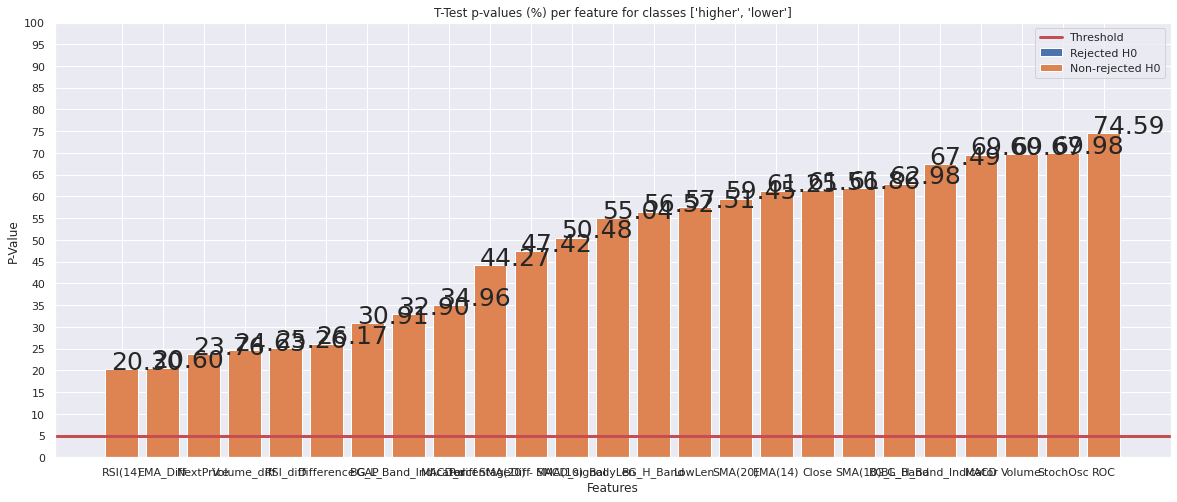

In [8]:
P_THRESH = 0.05


lowers = [(label, val) for label, val in feature_p_vals.items() if val <= P_THRESH]
highers = [(label, val) for label, val in feature_p_vals.items() if val > P_THRESH]


plt.bar([t[0] for t in lowers], [t[1]*100 for t in lowers], label="Rejected H0") 
plt.bar([t[0] for t in highers], [t[1]*100 for t in highers], label="Non-rejected H0")


x_locs, _ = plt.xticks()
for i, value in enumerate([x*100 for x in feature_p_vals.values()]):
    plt.text(x_locs[i] - 0.25, value + 0.01, f"{value:.2f}")
    
plt.axhline(y = P_THRESH * 100, color = 'r', linestyle = '-', linewidth=3.0, label="Threshold")
plt.yticks(np.arange(0, 101, step=5))
plt.title(f"T-Test p-values (%) per feature for classes {classes}")
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.show()

In [9]:
df_dict = StocksDataWrapper.import_folder(DATA_PATH, files_pattern="*.txt", compute_features=True, normalize=NORMALIZE_FEATURES, predict_n=predict_n)

higher_features_dict = {k:0 for k,v in feature_p_vals.items()}
lower_features_dict = {k:0 for k,v in feature_p_vals.items()}

# for each dataset given count the times where the features was higher or lower than the threshold
for (dataset, label) in tqdm(df_dict.items()):
    df = dataset.df
    feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)
    for k,v in feature_p_vals.items():
        try:
            if v > P_THRESH:
                higher_features_dict[k] += 1
            else:
                lower_features_dict[k] += 1
        except KeyError as e:
            print(f"Some key was filtered from the ")

  0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame(list(lower_features_dict.items()), columns=['Feature','Lower'])
# add the sum for the plot
df['Lower_Ratio'] = df['Lower'].apply(lambda x: float(x) / len(df_dict))
df['Sum'] = pd.Series(1.0 for val in zip(higher_features_dict.values(), lower_features_dict.values()))
df = df.sort_values(by='Lower', ascending=False)
df.loc[:, ['Feature', 'Lower_Ratio']]

,Feature,Lower_Ratio
2,NextPrice,0.636364
20,BG_H_Band_Indicator,0.363636
19,BG_L_Band,0.272727
9,PercentageDiff,0.181818
16,EMA(14),0.181818
22,Volume,0.181818
15,SMA(20),0.181818
13,BG_H_Band,0.181818
18,SMA(10),0.181818
14,LowLen,0.090909


In [11]:
#df.to_csv('features_comparison.csv', index=False)

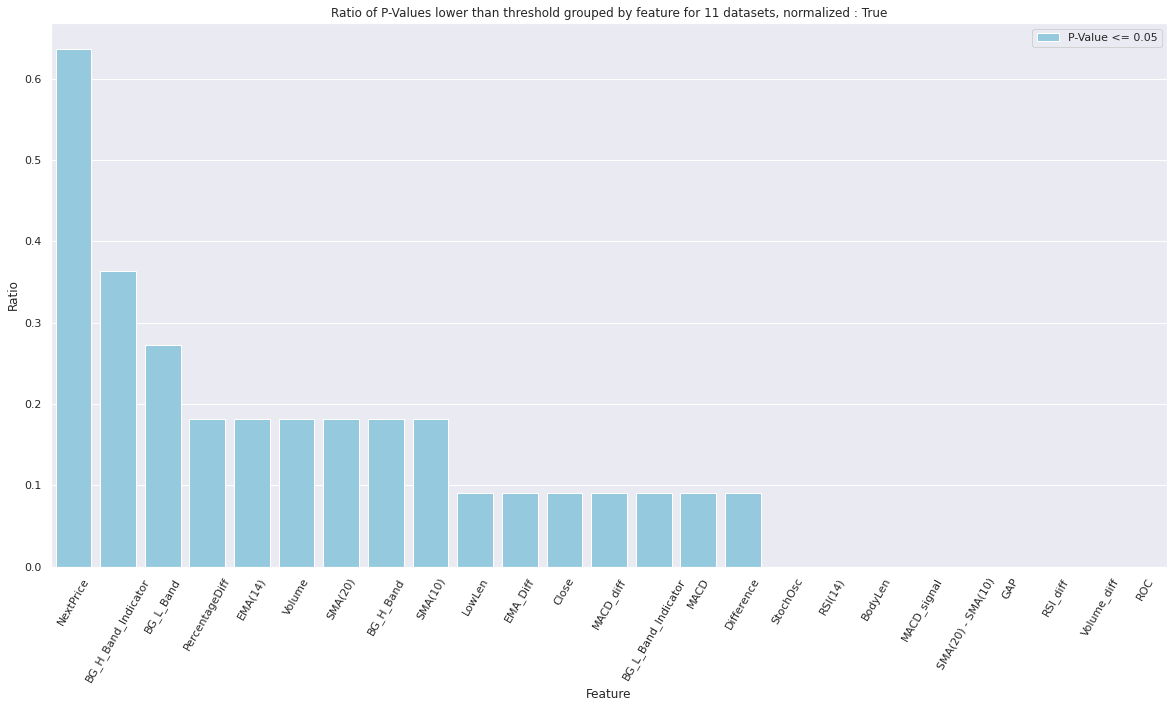

In [12]:
plt.figure(figsize=(20,10))

bar_lower = sns.barplot(x='Feature', y='Lower_Ratio', estimator=sum, data=df, color="skyblue", label=f"P-Value <= {P_THRESH}")
bar_lower.set_xticklabels(bar_lower.get_xticklabels(),rotation=60)
plt.title(f"Ratio of P-Values lower than threshold grouped by feature for {len(df_dict)} datasets, normalized : {NORMALIZE_FEATURES}")
plt.legend(loc='best')
plt.ylabel('Ratio')
plt.show()